In [12]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image
from datetime import datetime

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [353]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 910, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)

    bms = bmf.reshape(y, x)
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [439]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:int(ibegin + dist)])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [440]:

synclevel = 8900 # np.min(slpfdata[0:910*300])
whitetip = 44230 # np.max(slpfdata[0:910*300])

synclevel = np.min(slpfdata[0:910*300])
whitetip = np.max(slpfdata[0:910*300])

hz_ire_scale = (whitetip - synclevel) / 140

def RawToIRE(data):
    return ((np.float32(data) - synclevel) / hz_ire_scale) - 40

def IREToRaw(data):
    minire = (synclevel / hz_ire_scale) + 40
    return np.uint16((data + minire) * hz_ire_scale)

In [441]:
synclevel, hz_ire_scale, (synclevel / hz_ire_scale), IREToRaw(-40)

(6246.2155346697791, 246.31285790278349, 25.358869154671087, 6246)

In [442]:
75.26 * hz_ire_scale

18537.505685763488

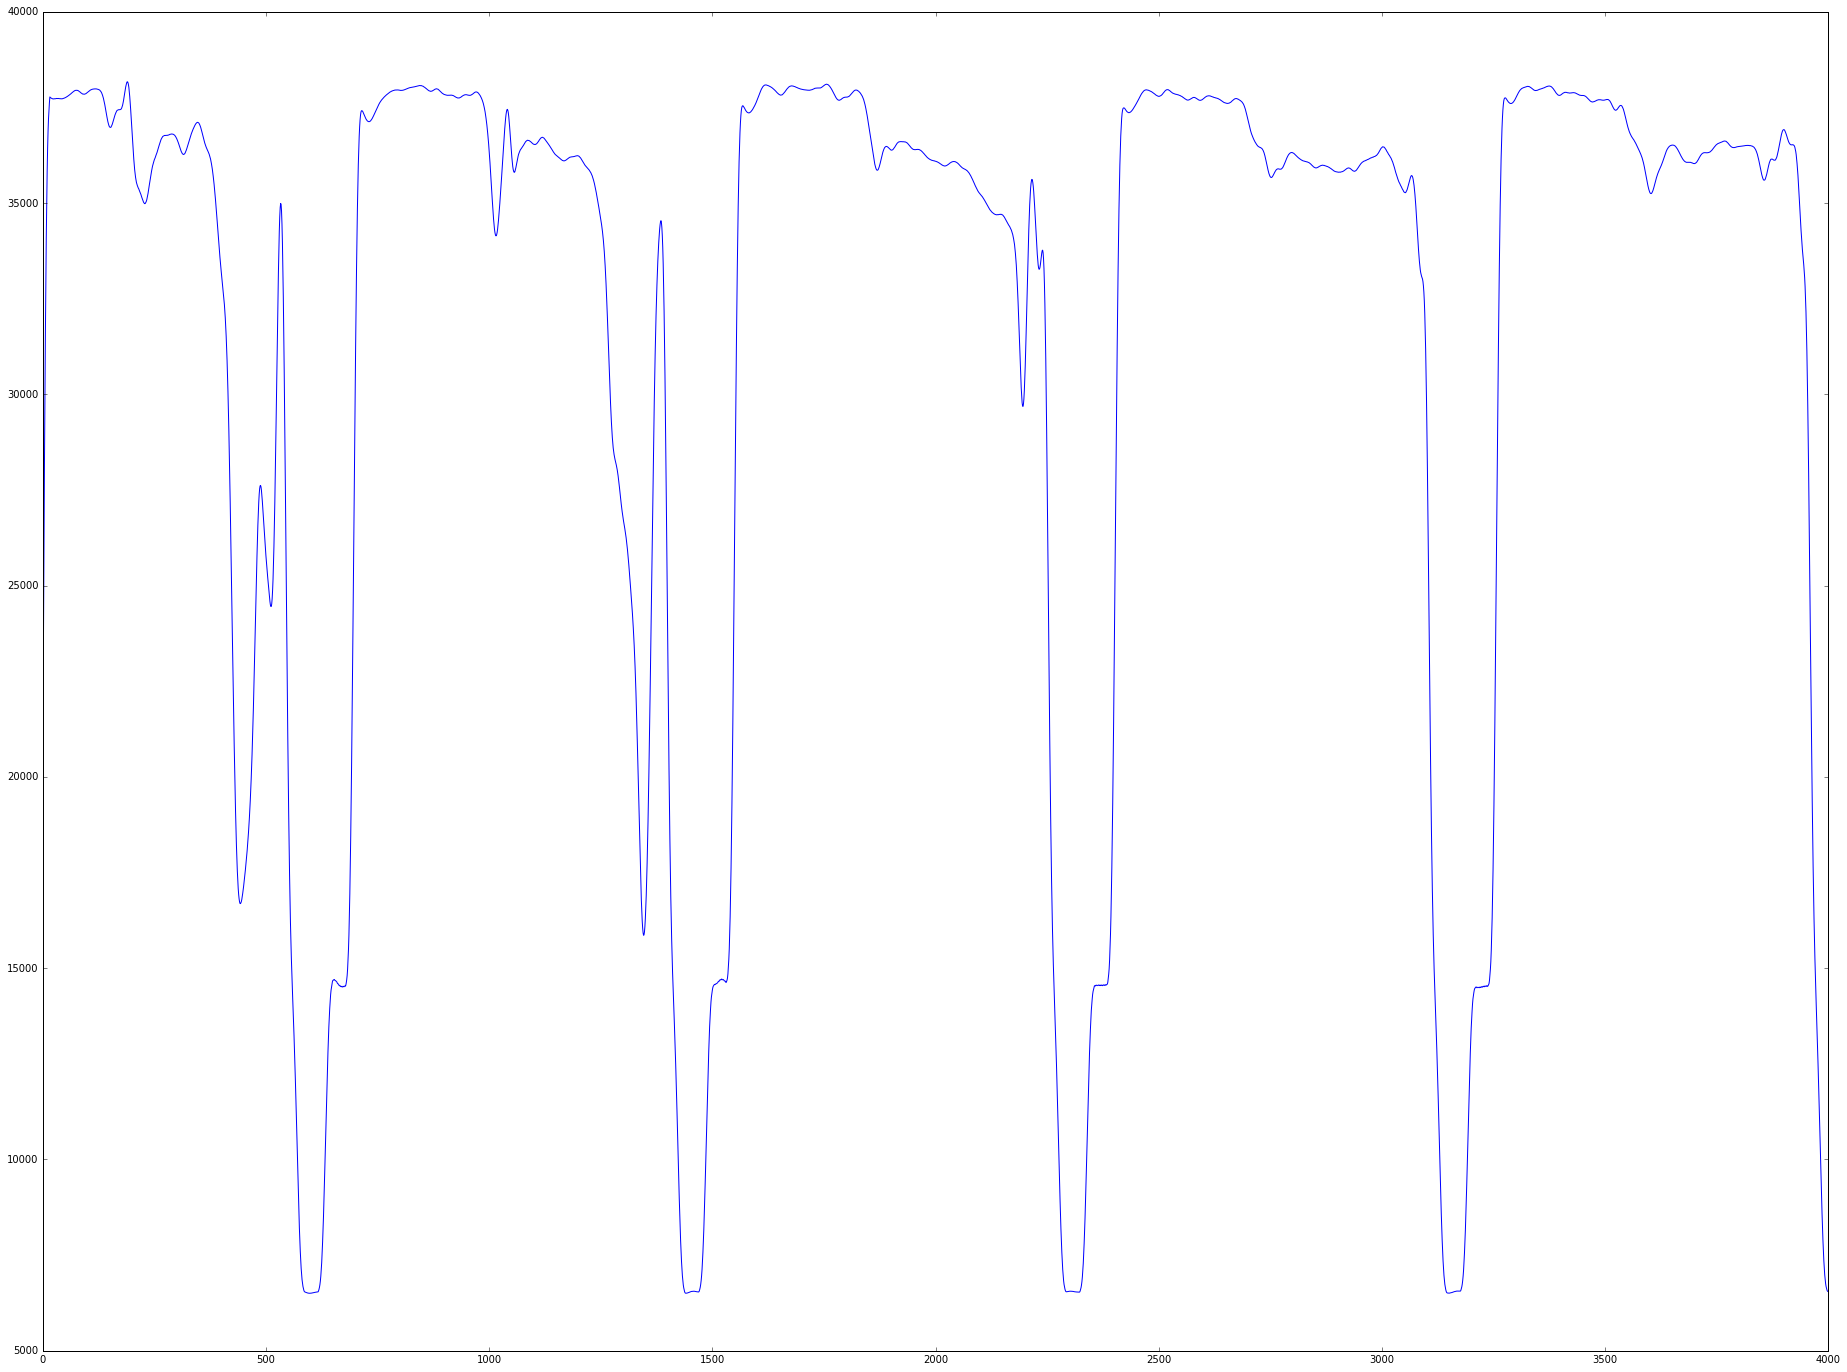

In [443]:
plt.plot(slpfdata[0:4000])

In [444]:
FSC = 4
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0
linelen = FSC * 227.5

synctrig = IREToRaw(-20)
rot_lowtrig = IREToRaw(-50) # should only happen during rot

# This is designed to smooth out small rot etc and clarify the sync intervals
f_slpf_offset = 16
f_slpf_b = sps.firwin((f_slpf_offset * 2) + 1, 100000/freq_hz)
f_slpf_a = [1.0]

# This is used to remove HF noise in rot detection check later
f_lpf_b = sps.firwin(49, 2000000/freq_hz)
f_lpf_a = [1.0]
f_lpf_offset = 24

burstfreq = 1000000 * 315/88.0

# This filter focuses on the color burst in an attempt to improve alignment on noisy disks
f_burst_bpf_b = sps.firwin(49, [(burstfreq-250000)/freq_hz, (burstfreq+250000)/freq_hz])
f_burst_bpf_a = [1.0]
f_burst_bpf_offset = 24


In [445]:
infd = open('CAM_Cardston-etc_2.4ta', 'rb')

bufsize = 910 * 525 * 4
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

bpfdata = sps.lfilter(f_burst_bpf_b, f_burst_bpf_a, data)[f_lpf_offset:]
lpfdata = sps.lfilter(f_lpf_b, f_lpf_a, data)[f_lpf_offset:]
slpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data)[f_slpf_offset:]

# Before official rot correction, we need to remove low spikes to avoid confusing the sync filter
#data_despike = data.copy()
#data_despike[np.where(data < rot_lowtrig)] = IREToRaw(0)
#data_despike[np.where(data > IREToRaw(120))] = IREToRaw(120)



In [446]:
synclevel = np.min(slpfdata)
whitetip = np.max(slpfdata)
hz_ire_scale = (whitetip - synclevel) / 140

synclevel, whitetip

(6222.8142179646666, 41093.059405928863)

In [465]:
def find_hsyncs(fstart, fend, ForFrame = False):
    start = int(fstart)
    end = int(fend)
    
    dl = np.where(np.diff(slpfdata[start:end] < IREToRaw(-30)))[0] + start
    dld = np.diff(dl)

    print(start, end, len(dld))
    
    hsyncs = []

    start = 1 if (dld[0] < (20 * FSC)) else 2

    for i in range(start, len(dld), 2):
        if ForFrame and len(hsyncs) == 0 and (dl[i + 1] - dl[i]) < (200 * FSC):
            continue
                
        hsyncs.append((dl[i], dl[i + 1], dld[i] + dld[i - 1], dld[i], dld[i - 1]))
        
    return hsyncs
    
print(IREToRaw(-30))
find_hsyncs(0, 400000)

8713
0 400000 957


[(629, 1426, 853, 797, 56),
 (1482, 2279, 853, 797, 56),
 (2335, 3132, 853, 797, 56),
 (3188, 3985, 853, 797, 56),
 (4041, 4839, 854, 798, 56),
 (4894, 5692, 853, 798, 55),
 (5747, 6545, 853, 798, 55),
 (6600, 7398, 853, 798, 55),
 (7454, 8251, 853, 797, 56),
 (8307, 9104, 853, 797, 56),
 (9160, 9957, 853, 797, 56),
 (10013, 10810, 853, 797, 56),
 (10866, 11664, 854, 798, 56),
 (11719, 12517, 853, 798, 55),
 (12573, 13370, 853, 797, 56),
 (13427, 14223, 853, 796, 57),
 (14280, 15076, 853, 796, 57),
 (15133, 15929, 853, 796, 57),
 (15986, 16782, 853, 796, 57),
 (16839, 17636, 854, 797, 57),
 (17692, 18489, 853, 797, 56),
 (18545, 19342, 853, 797, 56),
 (19398, 20195, 853, 797, 56),
 (20252, 21048, 853, 796, 57),
 (21105, 21901, 853, 796, 57),
 (21958, 22754, 853, 796, 57),
 (22811, 23607, 853, 796, 57),
 (23632, 24034, 427, 402, 25),
 (24059, 24461, 427, 402, 25),
 (24485, 24887, 426, 402, 24),
 (24912, 25314, 427, 402, 25),
 (25339, 25740, 426, 401, 25),
 (25764, 26168, 428, 404, 24),


In [466]:
def find_vsync(start = 0):
    end = int(start + (300 * 227.5 * FSC))

    hsyncs = find_hsyncs(start, end)

    vsp = []

    for i in range(len(hsyncs)):
        if hsyncs[i][2] > (100 * FSC) and hsyncs[i][2] < (120 * FSC):
            if len(vsp) and (hsyncs[i][0] - vsp[0][1]) > (200 * 227.5 * FSC):
                break
            else:
                vsp.append((i, hsyncs[i][0], hsyncs[i][3] > (80 * FSC)))

#    for v in vsp:
#        print(v)
                
    vsync_start =  vsp[0][1]
    vsync_type = int(vsp[6][2]) + int(~vsp[-6][2])
    vsync_end_index = vsp[-1][0] + 1
    vsync_end = hsyncs[vsync_end_index][0] - hsyncs[vsync_end_index][3]

    return vsync_start, vsync_type, vsync_end

In [467]:
def decodeframe():
    start = 8192
    
    while True:
        vsi1 = find_vsync(start)
    
        if vsi1[1] == 2:
            break
            
        start += int(FSC * 227.5 * 200)

    vsi2 = find_vsync(vsi1[2] + int(227.5 * FSC * 200))
    
    hsyncs1 = find_hsyncs(vsi1[2] - (8 * FSC), vsi1[2] + (270 * 227.5 * FSC), ForFrame = True)
    hsyncs2 = find_hsyncs(vsi2[2] - (8 * FSC), vsi2[2] + (270 * 227.5 * FSC), ForFrame = True)

    img = np.zeros((505, 844), dtype=np.float32)
    line = []
    
    # Stage 1: compute frames
    for i in range(0, 252):
        img[(i * 2)] = scale(data, hsyncs1[i][0], hsyncs1[i][1], 844)
        line.append((hsyncs1[i][0], hsyncs1[i][1]))
        img[(i * 2) + 1] = scale(data, hsyncs2[i][0], hsyncs2[i][1], 844)
        line.append((hsyncs2[i][0], hsyncs2[i][1]))
        
    line = np.array(line)
    
    return img, line
    
frame, lines = decodeframe()

8192 281192 675
190192 463192 631
436000 709000 643
253968 499700 564
490832 736564 589


/home/cpage/.local/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [468]:
lines[0]

array([254833, 255666])

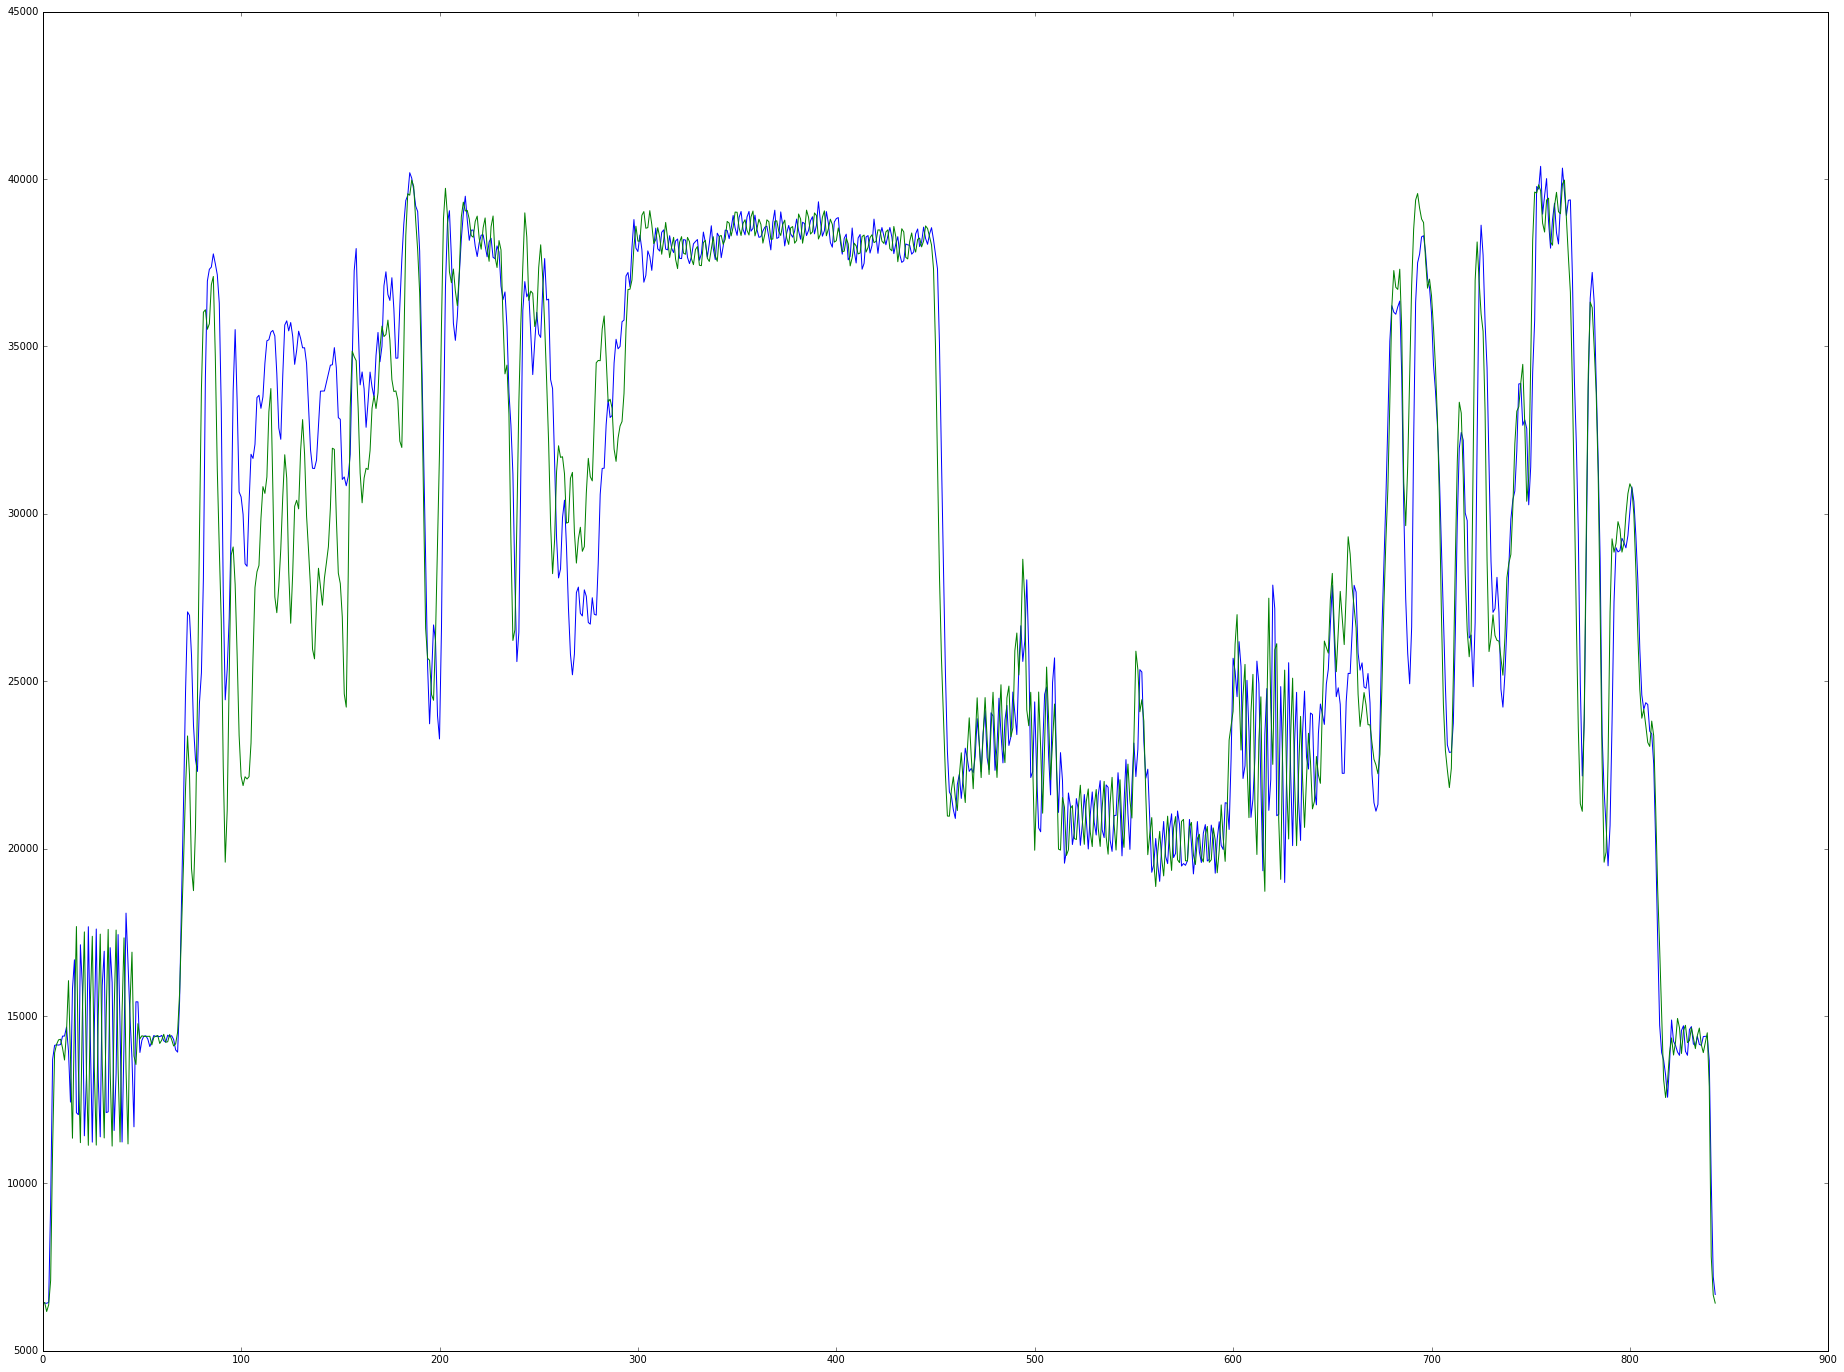

In [474]:
plt.plot(frame[352])
plt.plot(frame[353])

(505, 844)
uint8 (505, 844) (505, 844)


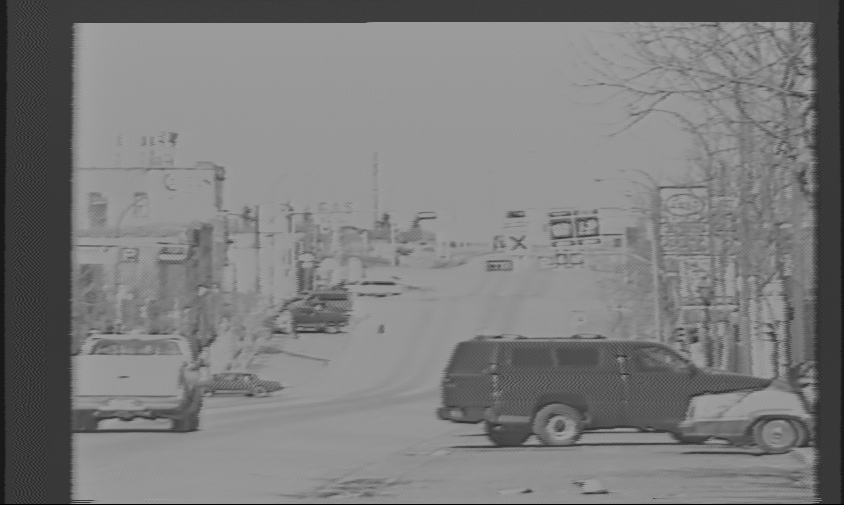

In [472]:
drawdata(frame, x=844, y=505)

In [291]:
find_vsync(0), find_vsyncs(0)

((201995, 0, 210172), (201995, 0, 210172))